In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import os
from IPython.display import display, clear_output

from utils import *

In [2]:
CONFIG_TRAIN = {
    "antenna_config": "siso",  # Antenna configuration
    "channel_model": "rayleigh",  # Channel type
    "M": 16,  # Number of constellation points
    "flag_train_model": True,  # Flag to control training
    "training_snr": 12,  # Training SNR (dB)
}

CONFIG_TRAIN["best_encoder_path"] = (
    f"./model/{CONFIG_TRAIN['antenna_config']}_{CONFIG_TRAIN['channel_model']}_{CONFIG_TRAIN['M']}qam_best_encoder.pt"
)
CONFIG_TRAIN["best_decoder_path"] = (
    f"./model/{CONFIG_TRAIN['antenna_config']}_{CONFIG_TRAIN['channel_model']}_{CONFIG_TRAIN['M']}qam_best_decoder.pt"
)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
encoder = Encoder([CONFIG_TRAIN["M"], 16, 16, 2]).to(device)
decoder = Decoder([2, 256, 256, CONFIG_TRAIN["M"]]).to(device)

In [4]:
def save_decoder(decoder, optimizer, loss):
    """
    Save the model to a file.
    - model_state_dict: the model state dictionary
    - optimizer_state_dict: the optimizer state dictionary
    - loss: the loss history
    """
    torch.save(
        {
            "model_state_dict": decoder.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": loss,
        },
        CONFIG_TRAIN["best_decoder_path"],
    )


def save_encoder(encoder, optimizer, loss):
    """
    Save the model to a file.
    - model_state_dict: the model state dictionary
    - optimizer_state_dict: the optimizer state dictionary
    - loss: the loss history
    """
    torch.save(
        {
            "Encoder": encoder.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": loss,
        },
        CONFIG_TRAIN["best_encoder_path"],
    )


def train_model(
    encoder, decoder, optimizer, max_iterations, loss_hist, num_messages, device
):
    """
    Train the encoder and decoder models over a specified number of iterations, handling noise and saving models when improved.

    Args:
        encoder (torch.nn.Module): The encoder part of the model.
        decoder (torch.nn.Module): The decoder part of the model.
        optimizer (torch.optim.Optimizer): Optimizer for both encoder and decoder.
        max_iterations (int): Total number of iterations to train the models.
        loss_hist (list): List to accumulate loss values over iterations for visualization.
        num_messages (int): Number of messages to process in one iteration.
        device (torch.device): The device (CPU/GPU) on which to run the training.

    Raises:
        KeyboardInterrupt: If the training is interrupted manually, save the models.
    """
    criterion = nn.NLLLoss()  # negative log likelihood loss
    best_loss = float("inf")  # Initialize the best loss to infinity
    try:
        for iterator in tqdm(
            range(len(loss_hist), max_iterations), desc="training process"
        ):
            # generate random messages
            messages = torch.randint(
                0, CONFIG_TRAIN["M"], size=(num_messages,), device=device
            )
            one_hot = F.one_hot(messages, CONFIG_TRAIN["M"]).float()
            tx = encoder(one_hot)
            rx = additive_white_gaussian_noise_channel(tx, CONFIG_TRAIN["training_snr"])
            y_pred_softmax = decoder(rx)

            loss = criterion(y_pred_softmax, messages)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())

            if loss.item() < best_loss:
                best_loss = loss.item()
                save_encoder(encoder, optimizer, loss_hist)
                save_decoder(decoder, optimizer, loss_hist)

            if (iterator % 100) == 0:
                clear_output(wait=True)

                # Print the accuracy
                y_pred = torch.argmax(y_pred_softmax, dim=1)
                SER = 1 - (messages == y_pred).float().mean()
                print(f"Iteration {iterator}: SER={SER:.2f}")

                # Plot the loss
                plt.semilogy(loss_hist)
                plt.xlabel("Iteration")
                plt.ylabel("Loss")
                plt.title("Training Loss")
                plt.show()
        print("Training complete")

    except KeyboardInterrupt:
        save_encoder(encoder, optimizer, loss_hist)
        save_decoder(decoder, optimizer, loss_hist)
        print("Training interrupted")

Iteration 1900: SER=0.10


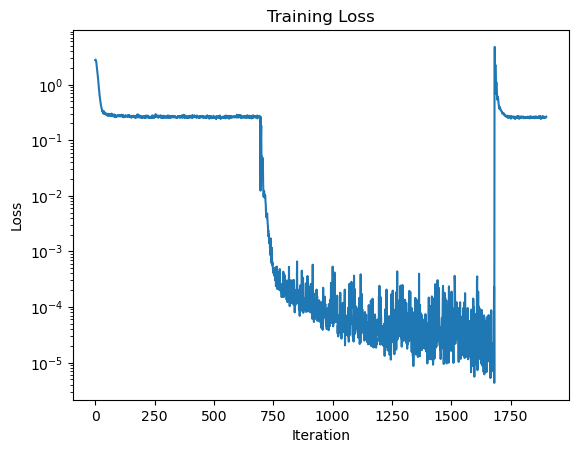

training process: 100%|██████████| 318/318 [00:10<00:00, 31.48it/s]

Training complete


In [5]:
if CONFIG_TRAIN["flag_train_model"]:
    # check if there is a checkpoint to resume training
    if os.path.exists(CONFIG_TRAIN["best_encoder_path"]) and os.path.exists(
        CONFIG_TRAIN["best_decoder_path"]
    ):
        encoder_checkpoint = torch.load(
            CONFIG_TRAIN["best_encoder_path"], map_location=device
        )
        decoder_checkpoint = torch.load(
            CONFIG_TRAIN["best_decoder_path"], map_location=device
        )
        encoder.load_state_dict(encoder_checkpoint["Encoder"])
        decoder.load_state_dict(decoder_checkpoint["model_state_dict"])

    parameters = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = Adam(parameters, lr=0.01)

    if os.path.exists(CONFIG_TRAIN["best_encoder_path"]) and os.path.exists(
        CONFIG_TRAIN["best_decoder_path"]
    ):
        # optimizer.load_state_dict(checkpoint["optimizer"])
        loss_hist = encoder_checkpoint["loss"]
        optimizer.load_state_dict(encoder_checkpoint["optimizer"])
        print(f"Resuming training from iterator {len(loss_hist)}")
    else:
        loss_hist = []
        print("Training from scratch")

    max_iterations = int(2e3)  # Total number of epochs to train
    num_messages = int(1e4)  # Number of messages to use for training (batch size)
    if max_iterations > len(loss_hist):
        train_model(
            encoder,
            decoder,
            optimizer,
            max_iterations,
            loss_hist,
            num_messages,
            device,
        )
    else:
        print("training already completed")
else:
    # check if there is a checkpoint to load the model
    if os.path.exists(CONFIG_TRAIN["best_encoder_path"]) and os.path.exists(
        CONFIG_TRAIN["best_decoder_path"]
    ):

        encoder_checkpoint = torch.load(
            CONFIG_TRAIN["best_encoder_path"], map_location=device
        )
        decoder_checkpoint = torch.load(
            CONFIG_TRAIN["best_decoder_path"], map_location=device
        )
        encoder.load_state_dict(encoder_checkpoint["Encoder"])
        decoder.load_state_dict(decoder_checkpoint["model_state_dict"])
        print("Model loaded. Training iterator: ", len(encoder_checkpoint["loss"]))
    else:
        print(
            "Model not found, please set flag_train_model to True and train the model"
        )
        exit(1)

In [6]:
encoder_checkpoint = torch.load(CONFIG_TRAIN["best_encoder_path"], map_location=device)
decoder_checkpoint = torch.load(CONFIG_TRAIN["best_decoder_path"], map_location=device)
encoder.load_state_dict(encoder_checkpoint["Encoder"])
decoder.load_state_dict(decoder_checkpoint["model_state_dict"])

<All keys matched successfully>

In [7]:
SNR_dB = np.arange(0, 22, 2)
SER = np.array([])
iteration = tqdm(range(len(SNR_dB)), desc="simulation process")
for iterator in iteration:
    snr = SNR_dB[iterator]
    num_mess = 6400  # number of messages to test
    minErr = 1  # minimum number of errors
    minSym = 1e6  # minimum number of symbols
    totSym = 0  # total number of symbols
    totErr = 0  # total number of errors
    while totErr < minErr or totSym < minSym:
        messages = torch.randint(0, CONFIG_TRAIN["M"], size=(num_mess,)).to(device)
        one_hot = F.one_hot(messages).float()
        tx = encoder(one_hot)
        rx = additive_white_gaussian_noise_channel(tx, snr)

        y_pred_softmax = decoder(rx)

        y_pred = torch.argmax(y_pred_softmax, -1)

        err = torch.sum(torch.not_equal(messages, y_pred)).to("cpu").detach().numpy()

        totErr += err
        totSym += num_mess
    SER = np.append(SER, totErr / totSym)

simulation process:   0%|          | 0/11 [00:00<?, ?it/s]

simulation process: 100%|██████████| 11/11 [00:14<00:00,  1.34s/it]


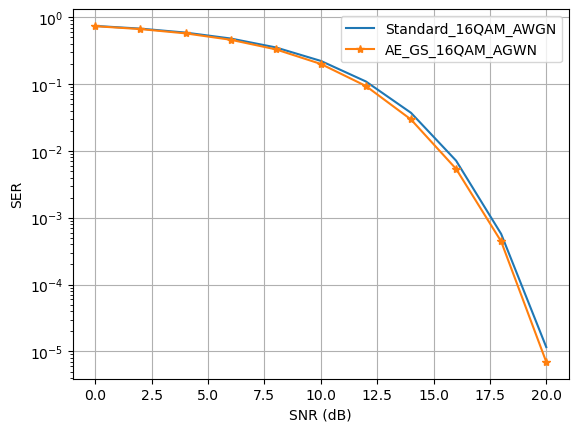

In [8]:
SER_theory = ser_mqam_awgn(CONFIG_TRAIN["M"], SNR_dB)
# plot the SER-SNR curve
plt.figure()
plt.xlabel("SNR (dB)")
plt.ylabel("SER")
plt.semilogy(SNR_dB, SER_theory, label="Standard_16QAM_AWGN")
plt.semilogy(SNR_dB, SER, "-*", label="AE_GS_{}QAM_AGWN".format(CONFIG_TRAIN["M"]))
plt.legend()
plt.grid(True)

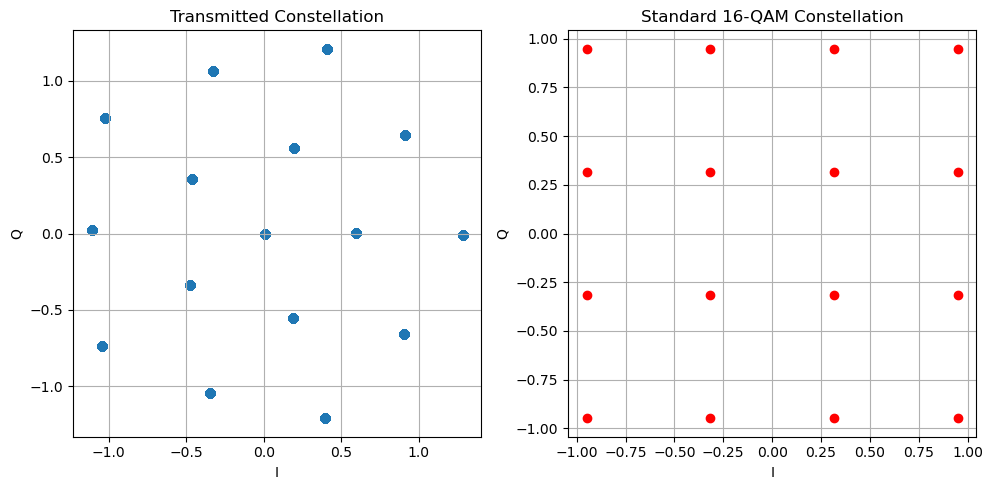

In [9]:
# Generate transmitted symbols using the encoder
num_mess = 6400  # number of messages to test
messages = torch.randint(0, CONFIG_TRAIN["M"], size=(num_mess,)).to(device)
one_hot = F.one_hot(messages).float()
tx = encoder(one_hot)
tx = tx.to("cpu").detach().numpy()

# Define the coordinates for 16-QAM constellation points
points_I = np.array([1, 1, 1, 1, -1, -1, -1, -1, 3, 3, 3, 3, -3, -3, -3, -3]) / np.sqrt(
    10
)
points_Q = np.array([3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3, 3, 1, -1, -3]) / np.sqrt(
    10
)

# Plot both constellations
plt.figure(figsize=(10, 5))

# Plot transmitted symbols
plt.subplot(1, 2, 1)
plt.scatter(tx[:, 0], tx[:, 1])
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Transmitted Constellation")
plt.grid(True)

# Plot standard 16-QAM constellation
plt.subplot(1, 2, 2)
plt.scatter(points_I, points_Q, c="r")
plt.xlabel("I")
plt.ylabel("Q")
plt.title("Standard 16-QAM Constellation")
plt.grid(True)

plt.tight_layout()
plt.show()